In [5]:
from scipy.special import roots_jacobi, eval_jacobi
import numpy as np
import scipy
import math

In [6]:
import matplotlib.pyplot as plt

### Initialization:

In [190]:
L = 12 # Denotes total length in [0, L]
M = 6 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

In [8]:
def int_points(x_range, npts, dx, M):
    
    k = 0
    p_order = npts - 1
    xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
    GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))
    GLL_dist = np.array([np.abs(GLL_points[0] - value) for value in GLL_points])
    
    return_array = np.zeros([M, npts])
    
    for i in x_range[:-1]:
        array = np.array([i])
        for j in GLL_dist[1:]: 
            scaled_point = ((j / 2) * (dx)) + i # Note: 2 here is the distance from -1 to 1
            array = np.concatenate((array, np.array([scaled_point])))
            
        return_array[k, :] = array
        k = k + 1
    
    return(return_array)

In [196]:
def init_Guassian(input_array, mu, sigma): 
    
    return_array = np.zeros_like(input_array)
    
    for i in np.arange(input_array.shape[0]):
        
        numerator = np.exp(-(input_array[i] - mu)**2 / (2 * sigma**2))
        denominator = sigma * np.sqrt(2 * np.pi)
        return_array[i, :] = numerator / denominator 
        
    return(return_array)

In [200]:
def Guassian_1st_deriv(input_array, mu, sigma):
    return(-(input_array - mu) / sigma**2 * init_Guassian(input_array, mu, sigma))

### Apply Derivative Operator to Elements:

In [15]:
def vandermonde(npts_values, return_type):
    # For the monomial basis: 
    if return_type == 'Monomial':
        return(np.vander(npts_values, increasing = True))
    elif return_type == 'Legendre':
        return(np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1))

In [32]:
def Ld_vandermonde(npts_values): 
    
    LP = np.polynomial.legendre
    v_matrix = np.polynomial.legendre.legvander(npts_values, len(npts_values)-1)
    d_v_matrix = np.zeros_like(v_matrix)

    for i in range(len(npts_values)):
        # Coefficients for the i-th Legendre polynomial (e.g., [0, 0, 1] for P_2)
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = 1

        # Compute the derivative of the i-th Legendre polynomial
        deriv_coeffs = LP.legder(coeffs, m=1) # m=1 for first derivative

        # Evaluate the derivative at the points x
        d_v_matrix[:, i] = LP.legval(npts_values, deriv_coeffs)
        
    return(d_v_matrix)

In [17]:
def Md_vandermonde(npts_values):
    
    v_matrix = np.vander(npts_values, increasing = True)
    d_v_matrix = np.zeros_like(v_matrix)
    
    for i in range(len(npts_values) - 1):
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = i + 1
        
        deriv_P = np.polynomial.polynomial.Polynomial(coeffs) 
        d_v_matrix[:, i + 1] = deriv_P(npts_values)
        
    return(d_v_matrix)

In [18]:
def return_D(V1, V2):
    return(np.matmul(V2, np.linalg.inv(V1)))

In [30]:
def deriv_elements(int_points, value_array, M):
    
    return_array = np.zeros_like(value_array)
    
    for i in np.arange(M): 
    
        V1 = vandermonde(int_points[i], 'Legendre')
        V2 = Ld_vandermonde(int_points[i])
        D = return_D(V1, V2)
        d_values = np.matmul(D, value_array[i].transpose())
        
        return_array[i] = d_values
        
    return(return_array)

In [66]:
deriv_values = deriv_elements(int_points(x_range, 4, L/M, M), 
                              init_Guassian(int_points(x_range, 4, L/M, M), (L/2), 1), M)

In [95]:
deriv_values.shape

(6, 4)

### Quick Plotting:

In [309]:
def plot_FEM(int_points, value_array, M):
    
    fig = plt.plot()
    
    for i in np.arange(M):
        plt.plot(int_points[i], value_array[i], marker = 'o')
        # plt.plot(fine_int_points[i], fine_value_array[i])

    return(fig)

def plot_FEM_ic(int_points, value_array, M):
     
    for i in np.arange(M):
        plt.plot(int_points[i], value_array[i], marker = '*', color = 'green')
        # plt.plot(fine_int_points[i], fine_value_array[i])

    return(fig)

In [173]:
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints
x_range[0] = 0.1

In [174]:
# Note: The num_pts variable is for each element; written for Legendre basis
def dV_multi_finegrid(x_range, n_order, num_pts, deriv_values):
    
    hold = 0
    LP = np.polynomial.legendre
    dv_finegrid = np.zeros([num_pts * (len(x_range) - 1), n_order])
    
    for i, j in enumerate(x_range[:-1]):
        # dx = np.diff(x_range)[0] / (num_pts) # Assuming element lengths are all equal 
        dx = (1/5)
        npts = np.arange(j, x_range[i+1], dx)
     
        for k in np.arange(n_order):
            coeffs = np.zeros(n_order)
            coeffs[k] = 1
            
            deriv_coeffs = LP.legder(coeffs, m=1)
        
            # We need to calculate (LP'(x) * LP^-1(x)): 
            d_P = LP.legval(npts, deriv_coeffs)
            P = np.polynomial.legendre.Legendre(coeffs)
            
            dv_finegrid[hold : hold + (num_pts), k] = (d_P / P(npts))
            
        hold = hold + num_pts
        
    return(dv_finegrid)

In [ ]:
dV_multi_finegrid(x_range, 4, 10, deriv_values)

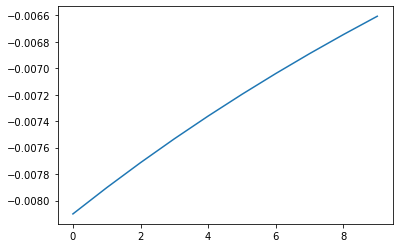

In [145]:
plt.plot(np.arange(0, 10), np.matmul(elem_4, deriv_values[4].transpose()))

[]

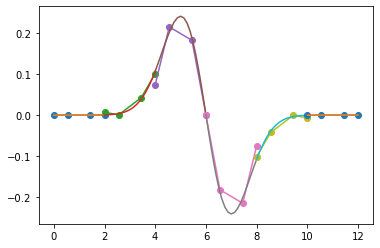

In [201]:
plot_FEM(int_points(x_range, 4, L/M, M), deriv_values, M,
         int_points(x_range, 25, L/M, M), Guassian_1st_deriv(int_points(x_range, 25, L/M, M), (L/2), 1))


### CG Boundary Averaging:

In [245]:
def boundary_mean(value_array, M):
    
    return_array = value_array.copy()
     
    for i in np.arange(M-1):
        mean_value = np.mean([value_array[i][-1], value_array[i+1][0]])
        return_array[i][-1] = mean_value
        return_array[i+1][0] = mean_value 
        
    # For the endpoints:
    return_array[-1][-1] = np.mean([value_array[-1][-1], value_array[0][0]])
    return_array[0][0] = np.mean([value_array[-1][-1], value_array[0][0]])
        
    return(return_array)

In [207]:
test = boundary_mean(deriv_values, M)

[]

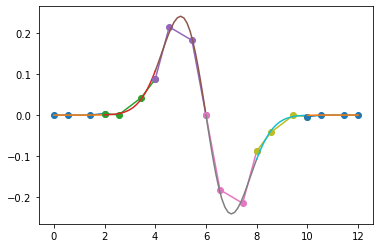

In [208]:
plot_FEM(int_points(x_range, 4, L/M, M), test, M,
         int_points(x_range, 25, L/M, M), Guassian_1st_deriv(int_points(x_range, 25, L/M, M), (L/2), 1))

### Applied to 1D Advection (with Predictor-Corrector Method):

In [270]:
# Initialize the elements and the Guassian function:
L = 12 # Denotes total length in [0, L]
M = 6 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

npts = int_points(x_range, 4, L/M, M)

In [271]:
# Compute the derivative matrix:
def SEM_dx(npts, u):
    
    u_out = np.zeros_like(u)
    
    for j in np.arange(npts.shape[0]):
        V1 = vandermonde(npts[j], 'Legendre')
        V2 = Ld_vandermonde(npts[j])
        D = return_D(V1, V2)
        
        u_out[j] = np.matmul(D, u[j].transpose())
        
    return(boundary_mean(u_out, u_out.shape[0]))

In [338]:
t_steps = 36
CFL = 0.10
dt = 0.1

u = init_Guassian(npts, (L/2), 1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u - ((dt / 2) * SEM_dx(npts, u))
    # Full time step:
    u_n = u - ((dt) * SEM_dx(npts, u_mid))
    
    # Prepare for the next timestep:
    u = u_n

Text(0.5, 1.0, 'IC & FEM Solution at t_step: 36')

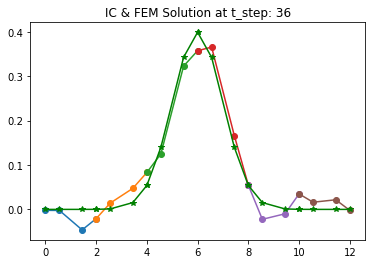

In [339]:
plot_FEM(npts, u, 6)
plot_FEM_ic(npts, init_Guassian(npts, (L/2), 1), 6)
plt.title('IC & FEM Solution at t_step: 36')

### Property Check -> Integration by Parts:

In [340]:
# Note: Quad weights only needs to defined for one element as all elements use the same functional space
# The weights are calculated using exact integration 

def quad_weights(npts_values):
    
    # Values in f_array result from exact integration:
    f_array = np.zeros(len(npts_values))
    f_array[0] = 2
    
    # Define basis matrix for Legendre polynomials: 
    V = np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1).transpose()
    
    return(np.matmul(np.linalg.inv(V), f_array.transpose()))

In [344]:
p_order = 3
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

quad_weights(GLL_points)

array([0.16666667, 0.83333333, 0.83333333, 0.16666667])

In [345]:
npts

array([[ 0.       ,  0.5527864,  1.4472136,  2.       ],
       [ 2.       ,  2.5527864,  3.4472136,  4.       ],
       [ 4.       ,  4.5527864,  5.4472136,  6.       ],
       [ 6.       ,  6.5527864,  7.4472136,  8.       ],
       [ 8.       ,  8.5527864,  9.4472136, 10.       ],
       [10.       , 10.5527864, 11.4472136, 12.       ]])